In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from librosa.filters import mel as librosa_mel_fn
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pickle
import csv
import sys, wave
import soundfile as sf

torch.manual_seed(0);
gpu_boole = torch.cuda.is_available()

## GETTING DATA:

In [4]:
AUDIO_LENGTH = 5000
OUTPUT_DIR = './drive/MyDrive/processed_heartbeat_data'
OUTPUT_DIR_TRAIN = os.path.join(OUTPUT_DIR, 'train')

train_files = glob(os.path.join(OUTPUT_DIR_TRAIN, '**.csv'))

In [32]:
def visualize_gen_waveform(data):
    print("Visualizing!")
    num_samples = len(data)
    t = np.linspace(0, 1, num_samples)
    plt.plot(t, data)
    plt.title("Generated Waveform")
    plt.show()

In [5]:
# shows the sound waves
def visualize_wav(path: str):
   
    # reading the audio file
    raw = wave.open(path)
     
    # reads all the frames
    # -1 indicates all or max frames
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
     
    # gets the frame rate
    f_rate = raw.getframerate()
 
    # to Plot the x-axis in seconds
    # you need get the frame rate
    # and divide by size of your signal
    # to create a Time Vector
    # spaced linearly with the size
    # of the audio file
    time = np.linspace(
        0, # start
        len(signal) / f_rate,
        num = len(signal)
    )
 
    # using matplotlib to plot
    # creates a new figure
    plt.figure(1)
     
    # title of the plot
    plt.title("Sound Wave")
     
    # label of x-axis
    plt.xlabel("Time")
    
    # actual plotting
    plt.plot(time, signal)
     
    # shows the plot
    # in new window
    plt.show()

In [6]:
def get_data(file_list):
    def load_into(_filename, _x):
        with open(_filename, 'rb') as f:
            audio_element = np.loadtxt(f, delimiter=",")
            audio_element = audio_element.reshape(1,5000)
            _x.append(audio_element)
    x = []
    count = 0
    for filename in file_list:
        if count < 10:
            load_into(filename, x)
        else:
            break
        #count += 1
        
    return np.array(x)

In [7]:
train_data = get_data(train_files)
print(train_data.shape)

(782, 1, 5000)


In [8]:
class Audio2Mel(nn.Module):
    def __init__(
        self,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        sampling_rate=22050,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=None,
    ):
        super().__init__()
        ##############################################
        # FFT Parameters                              #
        ##############################################
        window = torch.hann_window(win_length).float()
        mel_basis = librosa_mel_fn(
            sampling_rate, n_fft, n_mel_channels, mel_fmin, mel_fmax
        )
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer("mel_basis", mel_basis)
        self.register_buffer("window", window)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.sampling_rate = sampling_rate
        self.n_mel_channels = n_mel_channels

    def forward(self, audio):
        p = (self.n_fft - self.hop_length) // 2
        audio = F.pad(audio, (p, p), "reflect").squeeze(1)
        fft = torch.stft(
            audio,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
        )
        real_part, imag_part = fft.unbind(-1)
        magnitude = torch.sqrt(real_part ** 2 + imag_part ** 2)
        mel_output = torch.matmul(self.mel_basis, magnitude)
        log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
        return log_mel_spec

## CREATING ARCHITECTURE:

In [9]:
class generator(nn.Module):
    def __init__(self, input_channel):
        super(generator, self).__init__()
        self.reflPad1 = nn.ReflectionPad1d((3,3))
        self.conv1 = nn.Conv1d(input_channel, 1024, kernel_size=1, stride=1)
        self.dropout1 = nn.Dropout(0.8)
        self.act1 = nn.LeakyReLU(0.2)
        
        self.convTrans1 = nn.ConvTranspose1d(1024,512, kernel_size=81, stride=16, padding=4)
        self.dropout2 = nn.Dropout(0.7)
        self.act2 = nn.LeakyReLU(0.2)
        
        self.convTrans2 = nn.ConvTranspose1d(512,256, kernel_size=48, stride=8, padding=4)
        self.dropout3 = nn.Dropout(0.6)
        self.act3 = nn.LeakyReLU(0.2)
        
        self.convTrans3 = nn.ConvTranspose1d(256,128, kernel_size=24, stride=4, padding=1)
        self.dropout4 = nn.Dropout(0.5)
        self.act4 = nn.LeakyReLU(0.2)
        
        self.convTrans4 = nn.ConvTranspose1d(128,64,  kernel_size=18, stride=2, padding=1)
        self.act5 = nn.LeakyReLU(0.2)
        self.reflPad2 = nn.ReflectionPad1d((3,3))
        
        self.convTrans5 = nn.ConvTranspose1d(64,1, kernel_size=17, stride=1)
        self.out = nn.Tanh()

    def weight_init(self, mean, std):
        for m in self._modules:
            nn.normal_init(self._modules[m], mean, std)

    def forward(self, x):
        # reflPad1_out = self.reflPad1(x)
        conv1_out = self.conv1(x)
        act1_out = self.act1(conv1_out)
        act1_out = self.dropout1(act1_out)
        
        convTrans1_out = self.convTrans1(act1_out)
        act2_out = self.act2(convTrans1_out)
        act2_out = self.dropout2(act2_out)
        
        convTrans2_out = self.convTrans2(act2_out)
        act3_out = self.act3(convTrans2_out)
        act3_out = self.dropout3(act3_out)
        
        convTrans3_out = self.convTrans3(act3_out)
        act4_out = self.act4(convTrans3_out)
        act4_out = self.dropout4(act4_out)
        
        convTrans4_out = self.convTrans4(act4_out)
        act5_out = self.act5(convTrans4_out)
        act5_out = self.dropout4(act5_out)
        reflPad2_out = self.reflPad2(act5_out)
        
        convTrans5_out = self.convTrans5(reflPad2_out)
        result = self.out(convTrans5_out)
        return result 

In [10]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.RefPad = nn.ReflectionPad1d((7,7))
        self.conv1 = nn.Conv1d(1, 16, kernel_size=15, stride=1)
        self.act1 = nn.LeakyReLU(0.2)
        self.dropout1 = nn.Dropout(0.9)
        
        self.conv2 = nn.Conv1d(16, 64, kernel_size=8, stride=4, padding=20, groups=4)
        self.act2 = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(0.8)

        self.conv3 = nn.Conv1d(64, 256, kernel_size=16, stride=4, padding=20, groups=16)
        self.act3 = nn.LeakyReLU(0.2)
        self.dropout3 = nn.Dropout(0.7)

        self.conv4 = nn.Conv1d(256, 1024, kernel_size=32, stride=4, padding=20, groups=64)
        self.act4 = nn.LeakyReLU(0.2)
        self.dropout4 = nn.Dropout(0.6)

        self.conv5 = nn.Conv1d(1024, 1024, kernel_size=64, stride=4, padding=20, groups=256)
        self.act5 = nn.LeakyReLU(0.2)
        self.dropout5 = nn.Dropout(0.5)
        
        self.conv6 = nn.Conv1d(1024, 1024, kernel_size=16, stride=1, padding=2)
        self.act6 = nn.LeakyReLU(0.2)
            
        self.conv7 = nn.Conv1d(1024, 1, kernel_size=6, stride=1, padding=1)
        # self.pool = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)
        self.sig = nn.Sigmoid()

    def weight_init(self, mean, std):
        for m in self._modules:
            nn.normal_init(self._modules[m], mean, std)

    def forward(self, x):
        reflPad_out = self.RefPad(x)
        conv1_out = self.conv1(reflPad_out)
        act1_out = self.act1(conv1_out)
        act1_out = self.dropout1(act1_out)
        
        conv2_out = self.conv2(act1_out)
        act2_out = self.act2(conv2_out)
        act2_out = self.dropout1(act2_out)
        
        conv3_out = self.conv3(act2_out)
        act3_out = self.act3(conv3_out)
        act3_out = self.dropout1(act3_out)
        
        conv4_out = self.conv4(act3_out)
        act4_out = self.act4(conv4_out)
        act4_out = self.dropout1(act4_out)
        
        conv5_out = self.conv5(act4_out)
        act5_out = self.act5(conv5_out)
        act5_out = self.dropout1(act5_out)
        
        conv6_out = self.conv6(act5_out)
        act6_out = self.act6(conv6_out)
        act6_out = self.dropout1(act6_out)
        
        conv7_out = self.conv7(act6_out)
        result = self.sig(conv7_out)
        
        return result 

## TRAINING:

Training start!
[1/50] - loss_d: 1.726, loss_g: 0.654
hi
[2/50] - loss_d: 1.505, loss_g: 0.592
hi
[3/50] - loss_d: 1.402, loss_g: 0.611
hi
[4/50] - loss_d: 1.397, loss_g: 0.614
hi
[5/50] - loss_d: 1.573, loss_g: 0.566
hi
hello
Visualizing!


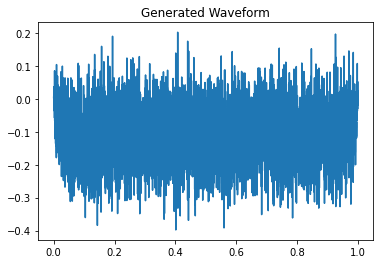

[6/50] - loss_d: 1.663, loss_g: 0.581
hi
[7/50] - loss_d: 1.917, loss_g: 0.582
hi
[8/50] - loss_d: 1.945, loss_g: 0.674
hi
[9/50] - loss_d: 1.993, loss_g: 0.729
hi
[10/50] - loss_d: 1.894, loss_g: 0.837
hi
hello
Visualizing!


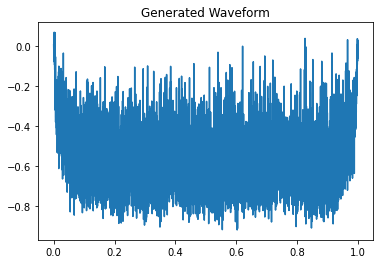

[11/50] - loss_d: 1.756, loss_g: 0.906
hi
[12/50] - loss_d: 1.636, loss_g: 0.902
hi
[13/50] - loss_d: 1.532, loss_g: 0.799
hi
[14/50] - loss_d: 1.446, loss_g: 0.796
hi
[15/50] - loss_d: 1.325, loss_g: 0.804
hi
hello
Visualizing!


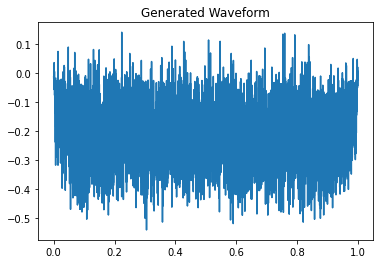

[16/50] - loss_d: 1.388, loss_g: 0.698
hi
[17/50] - loss_d: 1.394, loss_g: 0.638
hi
[18/50] - loss_d: 1.398, loss_g: 0.644
hi
[19/50] - loss_d: 1.460, loss_g: 0.617
hi
[20/50] - loss_d: 1.555, loss_g: 0.575
hi
hello
Visualizing!


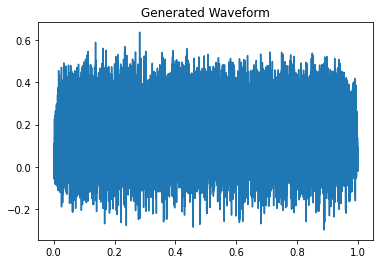

[21/50] - loss_d: 1.606, loss_g: 0.539
hi
[22/50] - loss_d: 1.653, loss_g: 0.581
hi
[23/50] - loss_d: 1.685, loss_g: 0.594
hi
[24/50] - loss_d: 1.786, loss_g: 0.785
hi
[25/50] - loss_d: 1.652, loss_g: 0.933
hi
hello
Visualizing!


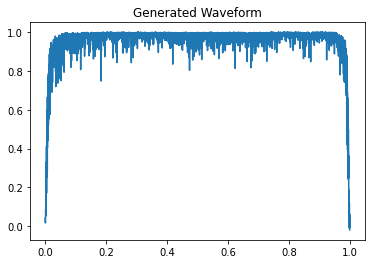

[26/50] - loss_d: 1.510, loss_g: 0.992
hi
[27/50] - loss_d: 1.344, loss_g: 1.091
hi
[28/50] - loss_d: 1.254, loss_g: 1.159
hi
[29/50] - loss_d: 1.138, loss_g: 1.234
hi
[30/50] - loss_d: 1.020, loss_g: 1.350
hi
hello
Visualizing!


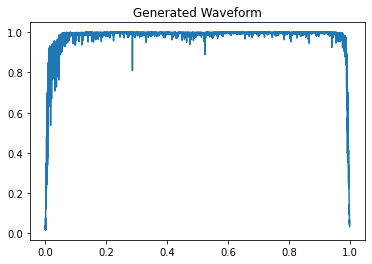

[31/50] - loss_d: 0.895, loss_g: 1.425
hi
[32/50] - loss_d: 0.839, loss_g: 1.528
hi
[33/50] - loss_d: 0.776, loss_g: 1.687
hi
[34/50] - loss_d: 0.688, loss_g: 1.764
hi
[35/50] - loss_d: 0.627, loss_g: 1.932
hi
hello
Visualizing!


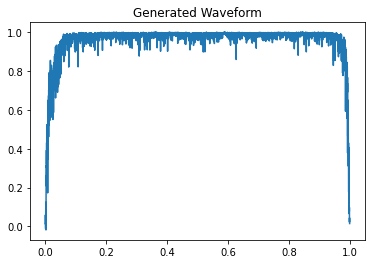

[36/50] - loss_d: 0.568, loss_g: 2.026
hi
[37/50] - loss_d: 0.530, loss_g: 2.054
hi
[38/50] - loss_d: 0.485, loss_g: 2.213
hi
[39/50] - loss_d: 0.433, loss_g: 2.355
hi
[40/50] - loss_d: 0.382, loss_g: 2.481
hi
hello
Visualizing!


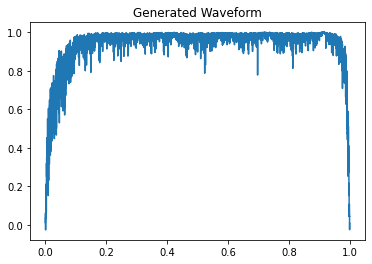

[41/50] - loss_d: 0.364, loss_g: 2.639
hi
[42/50] - loss_d: 0.330, loss_g: 2.752
hi
[43/50] - loss_d: 0.297, loss_g: 2.861
hi
[44/50] - loss_d: 0.295, loss_g: 2.900
hi
[45/50] - loss_d: 0.225, loss_g: 2.613
hi
hello
Visualizing!


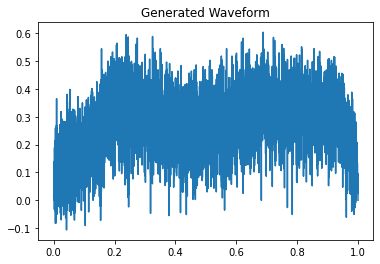

[46/50] - loss_d: 1.134, loss_g: 0.930
hi
[47/50] - loss_d: 2.764, loss_g: 0.283
hi
[48/50] - loss_d: 3.600, loss_g: 0.413
hi
[49/50] - loss_d: 4.239, loss_g: 0.372
hi
[50/50] - loss_d: 3.218, loss_g: 0.741
hi
hello
Visualizing!


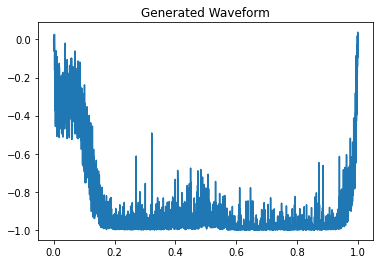

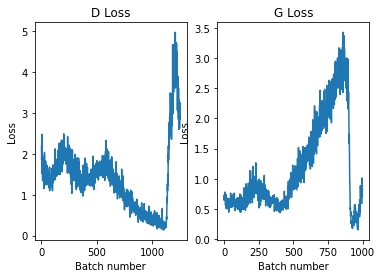

In [35]:
#Training code:

gpu_boole = torch.cuda.is_available()
cnn_boole = True #set True for CNN reshaping

# Hyperparameters
k=20
epochs = 50
batch_size = 32
lr_g = 0.00002
lr_d = 0.00002
train_interval = 5

# Models
G = generator(k)
D = discriminator()
# print(G)
# print(D)

if gpu_boole:
    G = G.cuda()
    D = D.cuda()
    
# DataLoader:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True)

# Optimizers:
G_optimizer = optim.Adam(G.parameters(), lr=lr_g)
D_optimizer = optim.Adam(D.parameters(), lr=lr_d)
fft = Audio2Mel(n_mel_channels=k)

# Loss:
BCELoss = nn.BCELoss()

# Training Loop:
D_losses = []
G_losses = []
print("Training start!")
for epoch in range(epochs):
    batch_number = 0
    for x_ in train_loader:
        batch_number += 1
        #reshaping depending on your architecture class:
        #if not cnn_boole:
            #x_ = x_.view(batch_size,-1) #this reshape is needed for MLP class
        if gpu_boole:
            x_ = x_

        # Attaching to CUDA
        x_ = x_.float().cuda()
        
        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        if gpu_boole:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()
        z_ = torch.randn((mini_batch, k))

        if cnn_boole:
            z_ = z_.view(-1, k, 1) #needed for CNN        
        if gpu_boole:
            z_ = z_.cuda()
            
        # Discriminator training
        D_pred_real = D(x_)
        D_pred_real = torch.reshape(D_pred_real, (-1,))
        D_real_loss = BCELoss(D_pred_real, y_real_)

        fake_images = G.forward(z_)
        D_pred_fake = D.forward(fake_images)
        D_pred_fake = torch.reshape(D_pred_fake, (-1,))

        D_fake_loss = BCELoss(D_pred_fake, y_fake_)
        
        D_train_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step()
        D_losses.append(D_train_loss.data.item())
        
        # Generator training
        if batch_number % train_interval != 0:
            z_ = torch.randn((mini_batch, k))
            if cnn_boole:
                z_ = z_.view(-1, k, 1) #needed for CNN        
            if gpu_boole:
                z_ = z_.cuda()
            fake_images = G.forward(z_)
            G_pred_fake = D.forward(fake_images)
            G_pred_fake = torch.reshape(G_pred_fake, (-1,))
            G_train_loss = BCELoss(G_pred_fake, y_real_)

            G.zero_grad()
            G_train_loss.backward()
            G_optimizer.step()

            G_losses.append(G_train_loss.data.item())

    # Printing the epoch loss
    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), epochs, torch.mean(torch.FloatTensor(D_losses[-batch_number:])),
                                        torch.mean(torch.FloatTensor(G_losses[-(batch_number - batch_number // train_interval):]))))

    # Print out every fifth epoch's first generated waveform
    if (epoch + 1) % 5 == 0:
        output_wave = fake_images[0, :, :].cpu().detach().numpy().reshape(-1)
        visualize_gen_waveform(output_wave)
        

# Saving the model
dt_string = datetime.now().strftime("%d-%m-%Y_%H:%M:%S.pt")

g_name = "Simon-GAN_G"
d_name = "Simon-GAN_D"

g_save_name = g_name + "_" + dt_string
d_save_name = d_name + "_" + dt_string

g_path = f"drive/My Drive/GAN_Saved_Models/{g_save_name}"
d_path = f"drive/My Drive/GAN_Saved_Models/{d_save_name}"

torch.save(G.state_dict(), g_path)
torch.save(D.state_dict(), d_path)

#Plotting:

#Losses:
plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("D Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("G Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

In [36]:
z_ = torch.randn((mini_batch, k))
if cnn_boole:
    z_ = z_.view(-1, k, 1) #needed for CNN        
if gpu_boole:
    z_ = z_.cuda()
fake_images = G.forward(z_)


for i in range(10):
  sf.write(f'drive/MyDrive/DL_FINAL_PROJECT/sample_outputs/sample_{i}.wav', fake_images[i].cpu().detach().numpy()[0], 22050)
  visualize_wav(f"./drive/MyDrive/DL_FINAL_PROJECT/sample_outputs/sample_{i}.wav")

RuntimeError: ignored